In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import talib 
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression



In [315]:
startdate = '2017-01-1'
enddate= '2021-12-31'
scaler = MinMaxScaler()

In [316]:
dji = pdr.get_data_yahoo('^DJI', start=startdate, end=enddate)
dji_norm = pd.DataFrame(scaler.fit_transform(dji), columns=dji.columns)
n225 = pdr.get_data_yahoo("^N225", start=startdate, end=enddate)
n225_norm = pd.DataFrame(scaler.fit_transform(n225), columns=n225.columns)
hsi = pdr.get_data_yahoo("^HSI", start=startdate, end=enddate)
hsi_norm = pd.DataFrame(scaler.fit_transform(hsi), columns=hsi.columns)
sse = pdr.get_data_yahoo("000001.SS", start=startdate, end=enddate)
sse_norm = pd.DataFrame(scaler.fit_transform(sse), columns=sse.columns)


In [317]:
dji['Future Close'] = dji['Close'].shift(-1)
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2017-01-03,19938.529297,19775.929688,19872.859375,19881.759766,339180000,19881.759766,19942.160156
2017-01-04,19956.140625,19878.830078,19890.939453,19942.160156,280010000,19942.160156,19899.289062
2017-01-05,19948.599609,19811.119141,19924.560547,19899.289062,269920000,19899.289062,19963.800781
2017-01-06,19999.630859,19834.080078,19906.960938,19963.800781,277700000,19963.800781,19887.380859
2017-01-09,19943.779297,19887.380859,19931.410156,19887.380859,287510000,19887.380859,19855.529297
...,...,...,...,...,...,...,...
2021-11-15,36236.070312,36031.781250,36128.828125,36087.449219,280660000,36087.449219,36142.218750
2021-11-16,36316.609375,36076.179688,36076.179688,36142.218750,308290000,36142.218750,35931.050781
2021-11-17,36159.699219,35909.480469,36159.699219,35931.050781,358310000,35931.050781,35870.949219


In [340]:
def computeTarget(present_price, future_price):
    score = (( future_price - present_price ) / present_price ) * 100
    target = []
    for i in score:
        if i > 0.05:
            target.append(2)
        elif i < -0.05:
            target.append(1)
        else:
            target.append(0)
    return target
# 2 = up, 1 = down, 0 = sideway

In [341]:

target = computeTarget(dji['Close'], dji['Future Close'])

dji['Target'] = target
dji = dji.dropna()

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_44804/1434574038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dji['Target'] = target


In [342]:
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close,Target
Date,,,,,,,,
2017-01-03,19938.529297,19775.929688,19872.859375,19881.759766,339180000,19881.759766,19942.160156,2
2017-01-04,19956.140625,19878.830078,19890.939453,19942.160156,280010000,19942.160156,19899.289062,1
2017-01-05,19948.599609,19811.119141,19924.560547,19899.289062,269920000,19899.289062,19963.800781,2
2017-01-06,19999.630859,19834.080078,19906.960938,19963.800781,277700000,19963.800781,19887.380859,1
2017-01-09,19943.779297,19887.380859,19931.410156,19887.380859,287510000,19887.380859,19855.529297,1
...,...,...,...,...,...,...,...,...
2021-11-12,36147.628906,35934.589844,35963.781250,36100.308594,293180000,36100.308594,36087.449219,0
2021-11-15,36236.070312,36031.781250,36128.828125,36087.449219,280660000,36087.449219,36142.218750,2
2021-11-16,36316.609375,36076.179688,36076.179688,36142.218750,308290000,36142.218750,35931.050781,1


In [343]:
close = dji['Close']
high = dji['High']
low = dji['Low']
open = dji['Open']
volume  = dji['Volume']

In [344]:
ti = pd.DataFrame()
ti['SMA20'] = talib.SMA(close, timeperiod=20)
ti['SMA50'] = talib.SMA(close, timeperiod=50)
ti['SMA200'] = talib.SMA(close, timeperiod=200)
ti['EMA'] = talib.EMA(close, timeperiod=14)
ti['OBV'] = talib.OBV(close, volume)
ti['RSI14'] = talib.RSI(close, timeperiod=14)
ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
ti['aroondown'], ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
ti['BOP'] = talib.BOP(open, high, low, close)
ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
ti['CMO'] = talib.CMO(close, timeperiod=14)
ti['DX'] = talib.DX(high, low, close, timeperiod=14)
ti['macd'],ti['macdsignal'],ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
ti['MOM'] = talib.MOM(close, timeperiod=14)
ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
ti['ROC'] = talib.ROC(close, timeperiod=10)
ti['ROCP'] = talib.ROCP(close, timeperiod=10)
ti['ROCR'] = talib.ROCR(close, timeperiod=10)
ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
ti['slowk'], ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
ti['fastk'], ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
ti['TRIX'] = talib.TRIX(close, timeperiod=30)
ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
ti['Target'] = dji['Target']
ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,3.391800e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2017-01-04,NaN,NaN,NaN,NaN,6.191900e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-05,NaN,NaN,NaN,NaN,3.492700e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2017-01-06,NaN,NaN,NaN,NaN,6.269700e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-09,NaN,NaN,NaN,NaN,3.394600e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,35878.700977,35105.925547,34104.139404,35967.099727,3.824325e+10,60.092840,24.141995,23.682842,14.285714,71.428571,...,1.007838,100.783790,15.166204,31.797097,28.447375,15.166204,0.045709,51.125760,-43.282948,0
2021-11-15,35920.142969,35120.292734,34133.517100,35983.146326,3.796259e+10,59.727010,23.895160,23.179295,7.142857,64.285714,...,1.004834,100.483405,21.227432,21.085635,34.318504,21.227432,0.048812,47.777185,-44.478834,2
2021-11-16,35954.388477,35141.137109,34160.790791,36004.355982,3.827088e+10,60.821001,23.921669,22.839573,0.000000,57.142857,...,1.002485,100.248497,38.460274,24.951303,52.614944,38.460274,0.051693,45.702226,-41.507722,1


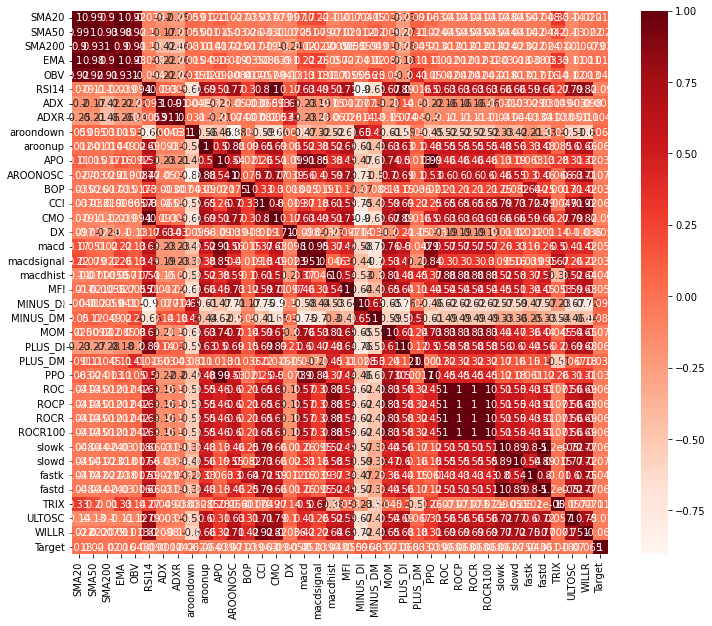

In [345]:
plt.figure(figsize=(12,10))
cor = ti.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [347]:
cor_target = abs(cor["Target"])
features = cor_target[cor_target>0.05]
features

RSI14        0.090006
aroondown    0.061562
aroonup      0.063776
AROONOSC     0.070903
CCI          0.062906
CMO          0.090006
macd         0.052112
MFI          0.054890
MINUS_DI     0.096109
MINUS_DM     0.083061
MOM          0.071080
PLUS_DI      0.067533
ROC          0.067667
ROCP         0.067667
ROCR         0.067667
ROCR100      0.067667
slowk        0.061832
slowd        0.074514
fastd        0.060686
ULTOSC       0.069887
WILLR        0.065219
Target       1.000000
Name: Target, dtype: float64

In [348]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable
y

Date
2017-10-17    2
2017-10-18    0
2017-10-19    2
2017-10-20    1
2017-10-23    2
             ..
2021-11-12    0
2021-11-15    2
2021-11-16    1
2021-11-17    1
2021-11-18    1
Name: Target, Length: 1031, dtype: int64

In [349]:
X = X.fillna(0)

In [350]:
X.isna().sum()

SMA20         0
SMA50         0
SMA200        0
EMA           0
OBV           0
RSI14         0
ADX           0
ADXR          0
aroondown     0
aroonup       0
APO           0
AROONOSC      0
BOP           0
CCI           0
CMO           0
DX            0
macd          0
macdsignal    0
macdhist      0
MFI           0
MINUS_DI      0
MINUS_DM      0
MOM           0
PLUS_DI       0
PLUS_DM       0
PPO           0
ROC           0
ROCP          0
ROCR          0
ROCR100       0
slowk         0
slowd         0
fastk         0
fastd         0
TRIX          0
ULTOSC        0
WILLR         0
dtype: int64

In [351]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, n_features_to_select=7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)

print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True False False False False False False
  True False  True False False False False  True  True False False  True
 False False False False False False  True False False False False False
 False]
[22 23 30 21 31  1  7 15 17 24 25 13  1 14  1 11 18 28 16  1  1 20 29  1
 19  6  3 27 26  8  1 10  2  9  4 12  5]


In [352]:
# no. of features
#
nof_list = np.arange(1, 13)            
high_score = 0

# Variable to store the optimum features
#
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)

    score = model.score(X_test_rfe,y_test)
    score_list.append(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.018762


In [353]:
cols = list(X.columns)
model = LinearRegression()

# Initializing RFE model
rfe = RFE(model, n_features_to_select=10)             

# Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

# Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['RSI14', 'BOP', 'CMO', 'MFI', 'MINUS_DI', 'PLUS_DI', 'ROC', 'slowk',
       'fastk', 'TRIX'],
      dtype='object')


In [354]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable
#Split the features and target data
#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
sfs.fit(X, y)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results


,feature_idx,cv_scores,avg_score,feature_names
1,"(19,)",[0.010457128340374267],0.010457,"(MFI,)"
2,"(12, 19)",[0.012624641730534125],0.012625,"(BOP, MFI)"
3,"(11, 12, 19)",[0.014098171932829584],0.014098,"(AROONOSC, BOP, MFI)"
4,"(11, 12, 19, 24)",[0.015191262686799822],0.015191,"(AROONOSC, BOP, MFI, PLUS_DM)"
5,"(11, 12, 19, 24, 31)",[0.016242097468920913],0.016242,"(AROONOSC, BOP, MFI, PLUS_DM, slowd)"


In [355]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable

sffs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=True,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
feature_names=ti.columns
sffs.fit(X, y,)

#Create a dataframe for the SFS results 
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(19,)",[0.010457128340374267],0.010457,"(MFI,)"
2,"(12, 19)",[0.012624641730534125],0.012625,"(BOP, MFI)"
3,"(11, 12, 19)",[0.014098171932829584],0.014098,"(AROONOSC, BOP, MFI)"
4,"(11, 12, 19, 24)",[0.015191262686799822],0.015191,"(AROONOSC, BOP, MFI, PLUS_DM)"
5,"(11, 12, 19, 24, 31)",[0.016242097468920913],0.016242,"(AROONOSC, BOP, MFI, PLUS_DM, slowd)"


<h2>จากการทำ Feature Selection ควรจะใช้ RSI14, APO, CMO, macd, macdsignal, MINUS_DI, MINUS_DM, MOM, PLUS_DI, PPO, ROC, ROCP, ROCP, ROCR100 ในการสร้าง model</h2>

In [358]:
from sklearn.model_selection import train_test_split
X = ti.loc[:, ['RSI14', 'BOP', 'CMO', 'MFI', 'MINUS_DI', 'PLUS_DI', 'ROC', 'slowk', 'fastk', 'TRIX']].values
y = ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

In [359]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [363]:
# Visualize the data
#
def visualize(title, xlabel, ylabel, classifier, X_test, y_test):
    X_set, y_set = X_test, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('lightblue', 'cornsilk')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [364]:
# Decision Tree Classifier: Create and Train the model
#
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [365]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2,
       0, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 1, 2, 2, 1, 1])

In [366]:
# Look at the actual y_test
#
y_test

array([[1],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [0],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [0],
       [0],
       [2],
       [2],
       [1],
       [2],
       [2],
       [1],
       [0],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [0],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
    

In [367]:
# See the accuracy
#
from sklearn import metrics
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

Accuracy Score: 0.48792270531400966
